# Example with tidal flume

In this simulation that seems to mimic a lab experiment, there is a long channel with one tidally forced boundary
on the left. At inflow on the left boundary salt sea-water will intrude into the channel. The channel is 130m
long, 1m wide and 20 cm deep. The "tide" on the left bounday has a period of 10 minutes and an amplitude of 0.75 cm. The inflowing water has a salinity of 12.5 psu. The net inflow on the right boundary is 0.005 m^3/s.
The simulation starts at rest with fresh water in the entire basin and finishes after 100 minutes, equaling 10 cycles.


In [2]:
# Load required libraries
using Pkg
Pkg.activate("..")
using Particles
using Plots
using Random
using ZipFile

randpool = MersenneTwister(0) #Generate same random numbers every time

nothing

  Activating project at `~/verlaan_shared/src/julia/Particles2`


In [3]:
# unzip the flow data (if not already done)

# function unzip(file,exdir="")
# extract all files from zip file to exdir
function unzip(file,exdir="")
    fileFullPath = isabspath(file) ?  file : joinpath(pwd(),file)
    basePath = dirname(fileFullPath)
    outPath = (exdir == "" ? basePath : (isabspath(exdir) ? exdir : joinpath(pwd(),exdir)))
    isdir(outPath) ? "" : mkdir(outPath)
    zarchive = ZipFile.Reader(fileFullPath)
    for f in zarchive.files
        fullFilePath = joinpath(outPath,f.name)
        if (endswith(f.name,"/") || endswith(f.name,"\\"))
            mkdir(fullFilePath)
        else
            write(fullFilePath, read(f))
        end
    end
    close(zarchive)
end

if !isdir("./data/tidal_flume_map.zarr") 
    unzip("./data/tidal_flume_map.zip","./data")
end


In [4]:
# Load default settings and adjust

# collected configuration is in Dict d
d = default_userdata() # start with some defaults

# settings for this experiment
n = 100 # number of particles
d["nparticles"] = n
# problem specific settings
x_min_release = 4.0 # release particles in this znode
d["x_min_release"] = x_min_release
x_max_release = 6.0 
d["x_max_release"] = x_max_release
z_min_release = -0.2  
d["z_min_release"] = z_min_release
z_max_release = -0.1
d["z_max_release"] = z_max_release
y_release = 1.0
d["y_release"] = y_release 

# all variables for one particle are collected in a vector
variables = ["x", "y", "z", "age"]
d["variables"] = variables
# initial position of the particles
m = length(variables)
p = zeros(m, n)
p[1, :] = x_min_release .+ (x_max_release - x_min_release) .* rand(randpool, n, 1) # x
p[2, :] .= y_release # y
p[3, :] = z_min_release .+ (z_max_release - z_min_release) .* rand(randpool, n, 1) # z
p[4, :] .= 0.0 # age
d["particles"] = p # initial values
# simulation time
d["dt"] = 30.0     #time-step
d["tstart"] = 1800.0 #start after 2 cycles
d["tend"]   = 3600.0
tstart=d["tstart"]
tend=d["tend"]
# write to netcdf
d["write_maps_times"] = collect(0.0:10.0:tend)
d["write_maps"] = false #do not write to netcdf
d["write_maps_filename"] = "output_tidal_flume.nc"
# write plots to file
d["plot_maps_times"] = collect(0.0:10.0:tend)
d["plot_maps"] = false # do not make png figures
d["plot_maps_size"]=(900,300)
d["plot_maps_func"] = plot_maps_xz

# keep some output in memory
d["keep_particles"] = true #keep results in memory (bad idea for a large run)
d["keep_particle_times"] = collect(tstart:30.0:tend)

d #show configuration

Dict{String, Any} with 29 entries:
  "plot_maps_prefix"     => "map"
  "write_maps"           => false
  "reftime"              => DateTime("2000-01-01T00:00:00")
  "particles"            => [5.6473 5.82071 … 5.39998 5.70041; 1.0 1.0 … 1.0 1.…
  "nparticles"           => 100
  "plot_maps_times"      => [0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.…
  "dt"                   => 30.0
  "tend"                 => 3600.0
  "write_maps_dir"       => "."
  "write_maps_filename"  => "output_tidal_flume.nc"
  "z_min_release"        => -0.2
  "variables"            => ["x", "y", "z", "age"]
  "x_min_release"        => 4.0
  "keep_particle_times"  => [1800.0, 1830.0, 1860.0, 1890.0, 1920.0, 1950.0, 19…
  "dumval"               => 9999.0
  "write_maps_as_series" => true
  "keep_particles"       => true
  "z_max_release"        => -0.1
  "plot_maps_func"       => plot_maps_xz
  ⋮                      => ⋮

In [5]:
# Load flow data and create interpolators

Zarr_data = ZarrData("./data","tidal_flume_map.zarr")
t0=get_reftime(Zarr_data)
h=initialize_interpolation(Zarr_data,"waterlevel",t0)
u=initialize_interpolation(Zarr_data,"x_velocity",t0)
function v(x,y,z,t) # interpolation of v is implemented but gives no useful addition to the zeros below
    return 0.0
end
function w(x,y,z,t) #TODO make interpolation of w work
    return 0.0
end
s=initialize_interpolation(Zarr_data,"salinity",t0)

nothing

┌ Info: Saved animation to /home/verlaan/verlaan_shared/src/julia/Particles2/case_tidal_flume/tidal_flume.gif
└ @ Plots /home/verlaan/.julia/packages/Plots/QWCV6/src/animation.jl:156


Plots.AnimatedGif("/home/verlaan/verlaan_shared/src/julia/Particles2/case_tidal_flume/tidal_flume.gif")
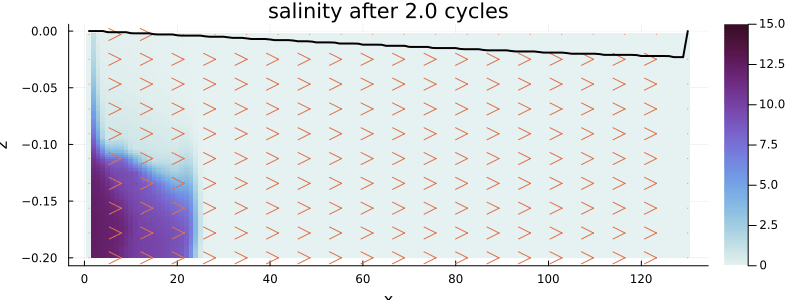

In [5]:
# create an animation of the flow field
x_left = 1.0
x_right = 130.0
y_middle = 1.0
z_surface = -0.003

z_bottom = -0.2
t_start=1200.0 #Skip first 20 minutes -= 2 cycles
t_step=60.0 # 6s in file, here coarser
t_stop=6000.0 #max 100minutes=6000s with steps 6s / period is 600s

#grid for plotting arrows
xgrid=collect(range(x_left,x_right,length=20))
zgrid=collect(range(z_bottom,z_surface,length=10))
nx=length(xgrid)
nz=length(zgrid)
xs=repeat(xgrid,1,nz)
zs=repeat(zgrid,1,nx)'

anim = @animate for t in range(t_start, stop = t_stop-t_step, step = t_step)
    # grid for plotting only
    x_points = range(x_left,stop=x_right,length=130)
    z_points = range(z_bottom,stop=z_surface,length=100)
    #u_interp = [u(x,y_middle,z,t) for x in x_points, z in z_points] # x velocity
    s_interp = [s(x,y_middle,z,t) for x in x_points, z in z_points] # salinity
    h_interp = [h(x,y_middle,0.0,t) for x in x_points] # water level

    #l = @layout([a; b])
    #p1=heatmap(x_points,z_points,u_interp',xlabel="x",ylabel="z",title="u velocity time=$(t)",clims=(-0.5,0.5))
    p2=heatmap(x_points,z_points,s_interp',xlabel="x",ylabel="z",title="salinity after $(t/600.0) cycles",clims=(0,15),color=:dense)
    quiver!(p2,vec(xs),vec(zs),quiver=(u.(vec(xs),y_middle,vec(zs),t),w.(vec(xs),y_middle,vec(zs),t)), arrowscale=0.6, headsize=0.1)
    #plot(p1,p2,layout=l,size=(800,300))
    plot!(p2,x_points,h_interp,label=false,linewidth=2,color=:black)
    plot(p2,size=(800,300))
end

gif(anim, "./tidal_flume.gif", fps = 4)

In [6]:
# Here is the equation that we want to solve for the particles

"""
   !f(ds,s,t,i,d)

Dynamic model, computes as ds the function f in the equation ds=f(s,t)dt+g(s,t)dw 
for s at current time t for particle i and possibly using data/functions from d of type userdata.
"""
function f!(∂s, s, t, i, d)
   x, y, z, age = s
   # dx/dt=u
    ∂s.x = u(x, y, z, t)
   # dy/dt=v
    ∂s.y = v(x, y, z, t)
   # dz/dt=0
    ∂s.z = w(x, y, z, t)
   # age=(t-t0)
    ∂s.t = 1.0
end
d["f"] = f!

#
# TODO: add function g! to simulate diffusion to simulation routine
#

"""
   !g(ds,s,t,i,d)

   Dynamic model, computes as ds the function g in the equation ds=f(s,t)dt+g(s,t)dw 
   for s at current time t for particle i and possibly using data/functions from d of type userdata.
"""
function g!(∂s, s, t, i, d)
   x, y, z, age = s
   # dx/dt=u
    ∂s.x = 0.0
   # dy/dt=v
    ∂s.y = 0.0
   # dz/dt=0
    ∂s.z = 0.0
   # age=(t-t0)
    ∂s.t = 0.0
end
d["g"] = g!

g! (generic function with 1 method)

In [7]:
#run the actual particle model

@time run_simulation(d)

writing output to memory at t = 

[1800.0, 1830.0, 1860.0, 1890.0, 1920.0, 1950.0, 1980.0, 2010.0, 2040.0, 2070.0  …  3330.0, 3360.0, 3390.0, 3420.0, 3450.0, 3480.0, 3510.0, 3540.0, 3570.0, 3600.0]
interrupt simulation for output at t = [1800.0, 1830.0, 1860.0, 1890.0, 1920.0, 1950.0, 1980.0, 2010.0, 2040.0, 2070.0  …  3330.0, 3360.0, 3390.0, 3420.0, 3450.0, 3480.0, 3510.0, 3540.0, 3570.0, 3600.0]
Simulation from time 1800.0 s to 3600.0 s since 2000-01-01T00:00:00 since 2000-01-01T00:00:00
t=1800.0 -> 1800.0  : 2000-01-01T00:30:00 -> 2000-01-01T00:30:00 : 0.0%


t=1800.0 -> 1830.0  : 2000-01-01T00:30:00 -> 2000-01-01T00:30:30 : 1.7%


t=1830.0 -> 1860.0  : 2000-01-01T00:30:30 -> 2000-01-01T00:31:00 : 3.3%
t=1860.0 -> 1890.0  : 2000-01-01T00:31:00 -> 2000-01-01T00:31:30 : 5.0%
t=1890.0 -> 1920.0  : 2000-01-01T00:31:30 -> 2000-01-01T00:32:00 : 6.7%
t=1920.0 -> 1950.0  : 2000-01-01T00:32:00 -> 2000-01-01T00:32:30 : 8.3%
t=1950.0 -> 1980.0  : 2000-01-01T00:32:30 -> 2000-01-01T00:33:00 : 10.0%
t=1980.0 -> 2010.0  : 2000-01-01T00:33:00 -> 2000-01-01T00:33:30 : 11.7%


t=2010.0 -> 2040.0  : 2000-01-01T00:33:30 -> 2000-01-01T00:34:00 : 13.3%
t=2040.0 -> 2070.0  : 2000-01-01T00:34:00 -> 2000-01-01T00:34:30 : 15.0%


t=2070.0 -> 2100.0  : 2000-01-01T00:34:30 -> 2000-01-01T00:35:00 : 16.7%
t=2100.0 -> 2130.0  : 2000-01-01T00:35:00 -> 2000-01-01T00:35:30 : 18.3%


t=2130.0 -> 2160.0  : 2000-01-01T00:35:30 -> 2000-01-01T00:36:00 : 20.0%
t=2160.0 -> 2190.0  : 2000-01-01T00:36:00 -> 2000-01-01T00:36:30 : 21.7%
t=2190.0 -> 2220.0  : 2000-01-01T00:36:30 -> 2000-01-01T00:37:00 : 23.3%
t=2220.0 -> 2250.0  : 2000-01-01T00:37:00 -> 2000-01-01T00:37:30 : 25.0%
t=2250.0 -> 2280.0  : 2000-01-01T00:37:30 -> 2000-01-01T00:38:00 : 26.7%
t=2280.0 -> 2310.0  : 2000-01-01T00:38:00 -> 2000-01-01T00:38:30 : 28.3%
t=2310.0 -> 2340.0  : 2000-01-01T00:38:30 -> 2000-01-01T00:39:00 : 30.0%


t=2340.0 -> 2370.0  : 2000-01-01T00:39:00 -> 2000-01-01T00:39:30 : 31.7%
t=2370.0 -> 2400.0  : 2000-01-01T00:39:30 -> 2000-01-01T00:40:00 : 33.3%
t=2400.0 -> 2430.0  : 2000-01-01T00:40:00 -> 2000-01-01T00:40:30 : 35.0%
t=2430.0 -> 2460.0  : 2000-01-01T00:40:30 -> 2000-01-01T00:41:00 : 36.7%
t=2460.0 -> 2490.0  : 2000-01-01T00:41:00 -> 2000-01-01T00:41:30 : 38.3%


t=2490.0 -> 2520.0  : 2000-01-01T00:41:30 -> 2000-01-01T00:42:00 : 40.0%
t=2520.0 -> 2550.0  : 2000-01-01T00:42:00 -> 2000-01-01T00:42:30 : 41.7%
t=2550.0 -> 2580.0  : 2000-01-01T00:42:30 -> 2000-01-01T00:43:00 : 43.3%
t=2580.0 -> 2610.0  : 2000-01-01T00:43:00 -> 2000-01-01T00:43:30 : 45.0%
t=2610.0 -> 2640.0  : 2000-01-01T00:43:30 -> 2000-01-01T00:44:00 : 46.7%


t=2640.0 -> 2670.0  : 2000-01-01T00:44:00 -> 2000-01-01T00:44:30 : 48.3%
t=2670.0 -> 2700.0  : 2000-01-01T00:44:30 -> 2000-01-01T00:45:00 : 50.0%
t=2700.0 -> 2730.0  : 2000-01-01T00:45:00 -> 2000-01-01T00:45:30 : 51.7%
t=2730.0 -> 2760.0  : 2000-01-01T00:45:30 -> 2000-01-01T00:46:00 : 53.3%
t=2760.0 -> 2790.0  : 2000-01-01T00:46:00 -> 2000-01-01T00:46:30 : 55.0%


t=2790.0 -> 2820.0  : 2000-01-01T00:46:30 -> 2000-01-01T00:47:00 : 56.7%
t=2820.0 -> 2850.0  : 2000-01-01T00:47:00 -> 2000-01-01T00:47:30 : 58.3%
t=2850.0 -> 2880.0  : 2000-01-01T00:47:30 -> 2000-01-01T00:48:00 : 60.0%
t=2880.0 -> 2910.0  : 2000-01-01T00:48:00 -> 2000-01-01T00:48:30 : 61.7%
t=2910.0 -> 2940.0  : 2000-01-01T00:48:30 -> 2000-01-01T00:49:00 : 63.3%
t=2940.0 -> 2970.0  : 2000-01-01T00:49:00 -> 2000-01-01T00:49:30 : 65.0%


t=2970.0 -> 3000.0  : 2000-01-01T00:49:30 -> 2000-01-01T00:50:00 : 66.7%
t=3000.0 -> 3030.0  : 2000-01-01T00:50:00 -> 2000-01-01T00:50:30 : 68.3%
t=3030.0 -> 3060.0  : 2000-01-01T00:50:30 -> 2000-01-01T00:51:00 : 70.0%
t=3060.0 -> 3090.0  : 2000-01-01T00:51:00 -> 2000-01-01T00:51:30 : 71.7%


t=3090.0 -> 3120.0  : 2000-01-01T00:51:30 -> 2000-01-01T00:52:00 : 73.3%
t=3120.0 -> 3150.0  : 2000-01-01T00:52:00 -> 2000-01-01T00:52:30 : 75.0%
t=3150.0 -> 3180.0  : 2000-01-01T00:52:30 -> 2000-01-01T00:53:00 : 76.7%


t=3180.0 -> 3210.0  : 2000-01-01T00:53:00 -> 2000-01-01T00:53:30 : 78.3%


t=3210.0 -> 3240.0  : 2000-01-01T00:53:30 -> 2000-01-01T00:54:00 : 80.0%
t=3240.0 -> 3270.0  : 2000-01-01T00:54:00 -> 2000-01-01T00:54:30 : 81.7%
t=3270.0 -> 3300.0  : 2000-01-01T00:54:30 -> 2000-01-01T00:55:00 : 83.3%
t=3300.0 -> 3330.0  : 2000-01-01T00:55:00 -> 2000-01-01T00:55:30 : 85.0%


t=3330.0 -> 3360.0  : 2000-01-01T00:55:30 -> 2000-01-01T00:56:00 : 86.7%
t=3360.0 -> 3390.0  : 2000-01-01T00:56:00 -> 2000-01-01T00:56:30 : 88.3%
t=3390.0 -> 3420.0  : 2000-01-01T00:56:30 -> 2000-01-01T00:57:00 : 90.0%
t=3420.0 -> 3450.0  : 2000-01-01T00:57:00 -> 2000-01-01T00:57:30 : 91.7%
t=3450.0 -> 3480.0  : 2000-01-01T00:57:30 -> 2000-01-01T00:58:00 : 93.3%


t=3480.0 -> 3510.0  : 2000-01-01T00:58:00 -> 2000-01-01T00:58:30 : 95.0%
t=3510.0 -> 3540.0  : 2000-01-01T00:58:30 -> 2000-01-01T00:59:00 : 96.7%
t=3540.0 -> 3570.0  : 2000-01-01T00:59:00 -> 2000-01-01T00:59:30 : 98.3%
t=3570.0 -> 3600.0  : 2000-01-01T00:59:30 -> 2000-01-01T01:00:00 : 100.0%
  6.445482 seconds (8.29 M allocations: 538.790 MiB, 8.56% gc time, 73.32% compilation time)


┌ Info: Saved animation to /home/verlaan/verlaan_shared/src/julia/Particles2/case_tidal_flume/tidal_flume.gif
└ @ Plots /home/verlaan/.julia/packages/Plots/QWCV6/src/animation.jl:156


Plots.AnimatedGif("/home/verlaan/verlaan_shared/src/julia/Particles2/case_tidal_flume/tidal_flume.gif")
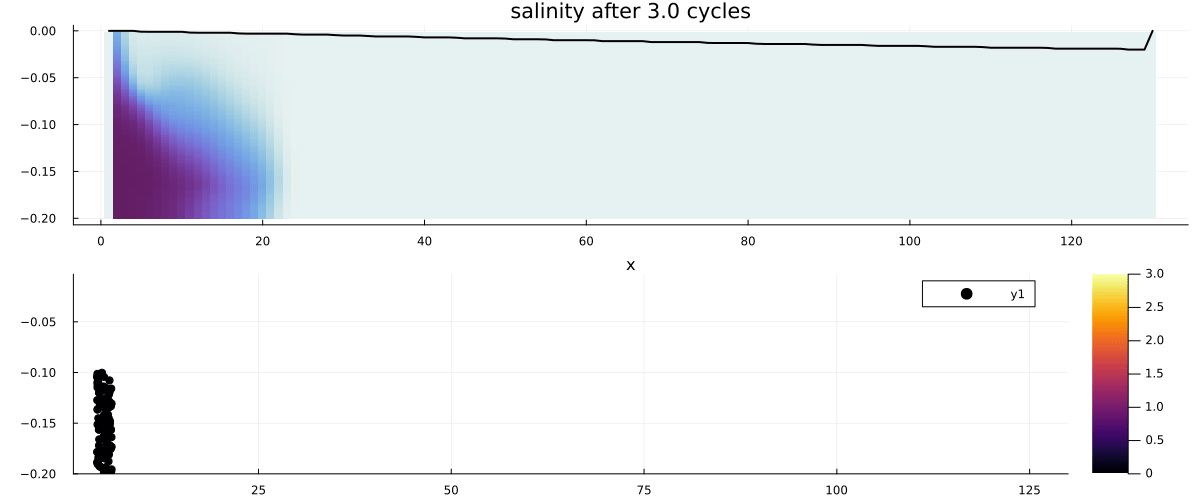

In [8]:
# create an animation of the flow field
x_left = 1.0
x_right = 130.0
y_middle = 1.0
z_surface = -0.003

z_bottom = -0.2
t_start=1800.0 #Skip first 30 minutes = 3 cycles
t_step=60.0 # 6s in file, here coarser
t_stop=3600.0 #max 100minutes=6000s with steps 6s / period is 600s

#grid for plotting arrows
xgrid=collect(range(x_left,x_right,length=20))
zgrid=collect(range(z_bottom,z_surface,length=10))
nx=length(xgrid)
nz=length(zgrid)
xs=repeat(xgrid,1,nz)
zs=repeat(zgrid,1,nx)'

anim = @animate for t in range(t_start, stop = t_stop-t_step, step = t_step)
    # grid for plotting only
    x_points = range(x_left,stop=x_right,length=130)
    z_points = range(z_bottom,stop=z_surface,length=100)
    #u_interp = [u(x,y_middle,z,t) for x in x_points, z in z_points] # x velocity
    s_interp = [s(x,y_middle,z,t) for x in x_points, z in z_points] # salinity
    h_interp = [h(x,y_middle,0.0,t) for x in x_points] # water level

    l = @layout([a ; b])
    p1=heatmap(x_points,z_points,s_interp',xlabel="x",ylabel="z",title="salinity after $(t/600.0) cycles",clims=(0,15),color=:dense,legend=false)
    plot!(p1,x_points,h_interp,label=false,linewidth=2,color=:black)
    # add particles
    itime=findmin(abs.(t.-d["keep_particle_times"]))[2]
    age=d["all_particles"][itime][4,:]./600.0 # in cycles
    #println("time=$(t/600.0) cycles, age=$(sum(age)/length(age))")
    p2=scatter(d["all_particles"][itime][1,:],d["all_particles"][itime][3,:],zcolor=age,clims=(0,3.0),xlims=(x_left,x_right),ylims=(z_bottom,z_surface))
    plot(p1,p2,size=(1200,500),layout=l)
end

gif(anim, "./tidal_flume.gif", fps = 4)